## Analyze data and build model for predict bike sharing information

In [ ]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sbr
sbr.set(font_scale=1.2)

%matplotlib inline

In [2]:
# you can download data from https://inclass.kaggle.com/c/hyperlee-1/data
train_df = pd.read_csv('data/bike_sharing_train.csv')
test_df = pd.read_csv('data/bike_sharing_test.csv')

In [3]:
print('Train shape: ', train_df.shape)
print('Test shape: ', test_df.shape)

Train shape:  (10886, 12)
Test shape:  (6493, 9)


In [9]:
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


#### Evaluate correlation between features

In [10]:
train_df.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,casual_log,registered_log,count_log
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439,0.167172,0.157381,0.160452
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393,0.029487,-0.008956,-0.001231
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594,-0.208715,0.031922,-0.015326
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655,-0.149943,-0.096462,-0.108005
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454,0.562596,0.330701,0.376587
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784,0.559950,0.326022,0.372167
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371,-0.366263,-0.317667,-0.333158
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369,0.116786,0.121142,0.122754
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414,0.780839,0.510717,0.579034
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948,0.629648,0.805086,0.792129


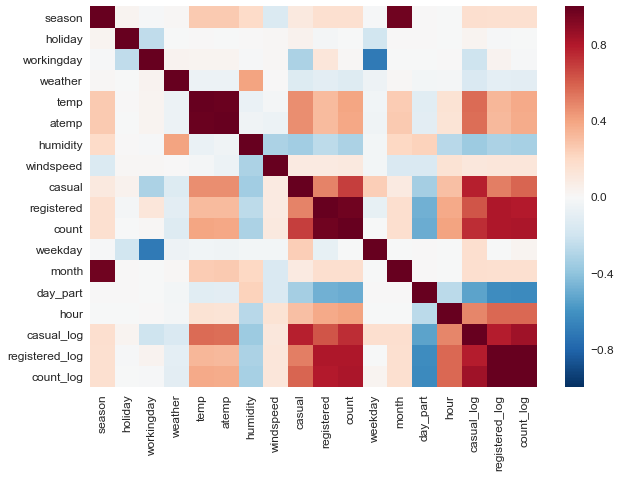

In [70]:
plt.figure(figsize=(10, 7))

sbr.heatmap(train_df.corr());

### The _temp_ and  _atemp_ are highly correlated. I'll gonna leave only temp

### Helpers

In [6]:
# http://scikit-learn.org/stable/auto_examples/hetero_feature_union.html
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [7]:
def make_submission(prediction, file_index):
    """Create submission for publick score
    
    Args:
        prediction (list): The list of the predictions
        file_index (str): The name of the file
    """
    subm = pd.DataFrame({'datetime': test_df.datetime, 'count': prediction})
    subm.to_csv('submissions/submission_{}.csv'.format(file_index), index=False)
    del subm
    
    print('submission_{}.csv successfully created'.format(file_index))

In [8]:
def evaluate_model(model, target_column):
    """Evaluate model for the training and cross-validation datasets

    Args:
        model : The trained model
        target_column (str): The name of the target column
    """
    print('Error on train:', rmsle(X_train[target_column], model.predict(X_train)))
    print('Error on test:', rmsle(X_test[target_column], model.predict(X_test)))

In [9]:
def predict_test(estimator, target_name):
    """Make prediction for testing datset
    
    Args:
        estimator : The trained model
        target_column (str): The name of the target column
    """
    estimator.fit(prepared_train, prepared_train[target_name])
    prediction = estimator.predict(prepared_test)

    return np.expm1(prediction)

In [10]:
# Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE) so lets define it. 
# Also we are using common mean absolute error

def rmsle(y, y_):
    log1 = np.nan_to_num(np.array([np.log1p(v) for v in y]))
    log2 = np.nan_to_num(np.array([np.log1p(v) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

### Feature engineering

In [11]:
def get_day_part(hour_value):
    if hour_value > 6 and hour_value < 10:
        return 1
    if hour_value >= 10 and hour_value < 16:
        return 2
    if hour_value >= 16 and hour_value < 20:
        return 3
    if hour_value >= 20 and hour_value < 24:
        return 4
    if hour_value >= 0 and hour_value <= 6:
        return 5

In [12]:
def create_feautes(df):
    df['weekday'] = df.datetime.apply(lambda p: pd.to_datetime(p).weekday())
    df['month'] = df.datetime.apply(lambda p: pd.to_datetime(p).month)
    df['day_part'] = df.datetime.apply(lambda p: get_day_part(pd.to_datetime(p).hour))
    df['hour'] = df.datetime.apply(lambda p: pd.to_datetime(p).hour)
    
    categorical_data_columns = ['season', 'weather', 'weekday', 'month', 'day_part', 'hour']
    dummy_df = pd.get_dummies(
        data=df[categorical_data_columns], columns=categorical_data_columns, prefix=categorical_data_columns
    )
    df = pd.concat([df, dummy_df], axis=1)
    del dummy_df
    
    return df

#### Prepare traing data

In [13]:
prepared_train = create_feautes(train_df)

In [14]:
prepared_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,...,0,0,0,0,0,0,0,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,...,0,0,0,0,0,0,0,0,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,...,0,0,0,0,0,0,0,0,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,...,0,0,0,0,0,0,0,0,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,...,0,0,0,0,0,0,0,0,0,0


#### Prepare testing data

In [15]:
prepared_test = create_feautes(test_df)

In [16]:
prepared_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,weekday,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,3,...,0,0,0,0,0,0,0,0,0,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,3,...,0,0,0,0,0,0,0,0,0,0
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,3,...,0,0,0,0,0,0,0,0,0,0
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,...,0,0,0,0,0,0,0,0,0,0
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,...,0,0,0,0,0,0,0,0,0,0


#### Logarithmic transformation of dependent columns

In [25]:
for col in ['casual', 'registered', 'count']:
    prepared_train['%s_log' % col] = np.log1p(train_df[col])

### Data visualization

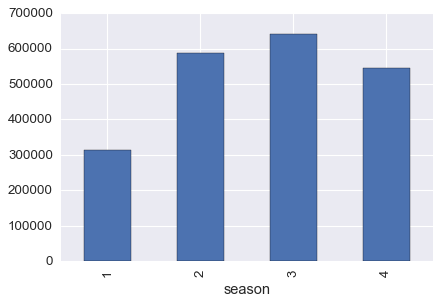

In [88]:
train_df.groupby('season')['count'].sum().plot.bar();

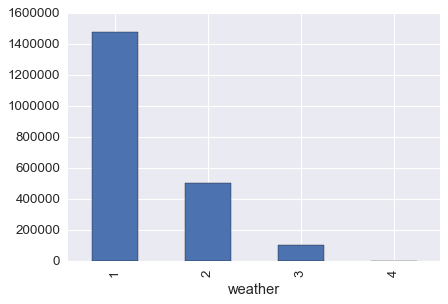

In [89]:
train_df.groupby('weather')['count'].sum().plot.bar();

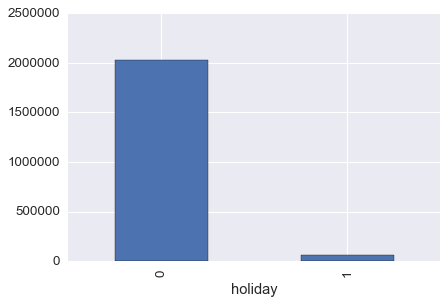

In [93]:
train_df.groupby('holiday')['count'].sum().plot.bar();

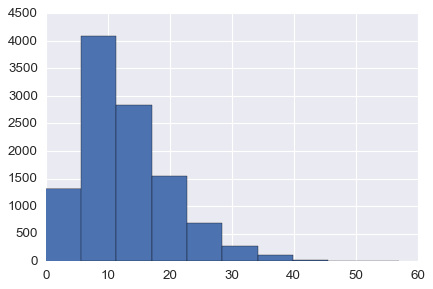

In [94]:
plt.hist(train_df.windspeed);

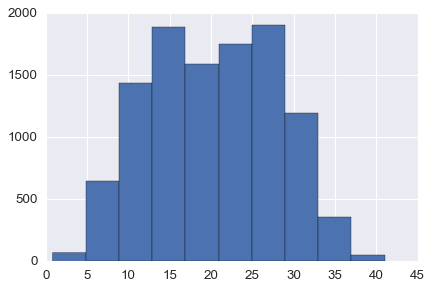

In [95]:
plt.hist(train_df.temp);

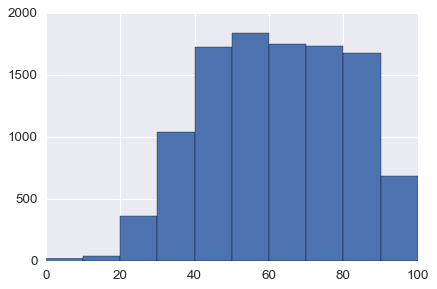

In [96]:
plt.hist(train_df.humidity);

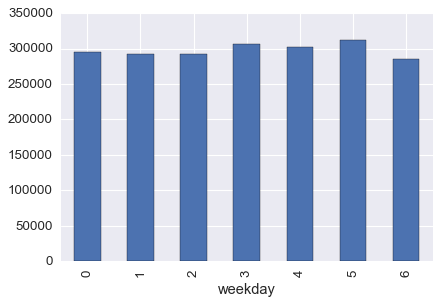

In [26]:
prepared_train.groupby('weekday')['count'].sum().plot.bar();

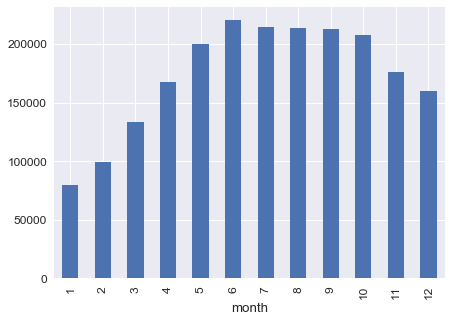

In [74]:
prepared_train.groupby('month')['count'].sum().plot.bar();

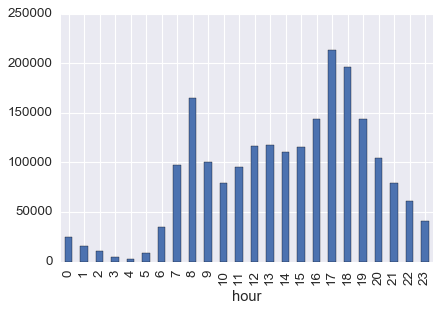

In [28]:
prepared_train.groupby('hour')['count'].sum().plot.bar();

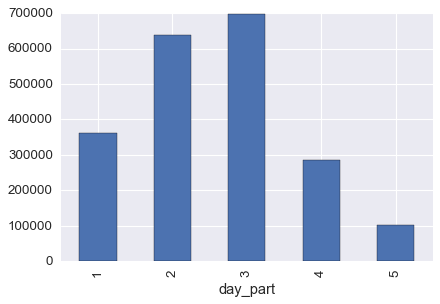

In [29]:
prepared_train.groupby('day_part')['count'].sum().plot.bar();

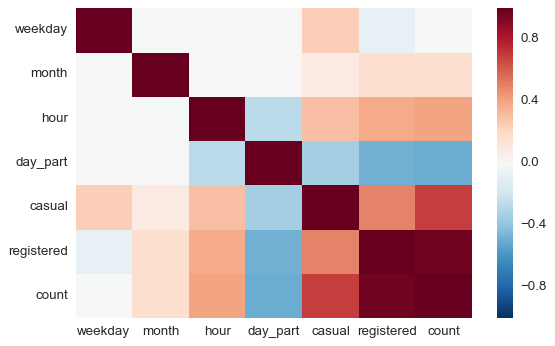

In [100]:
# Correlations with datatime features
plt.figure(figsize=(8, 5))
sbr.heatmap(prepared_train[['weekday', 'month', 'hour', 'day_part', 'casual', 'registered', 'count']].corr());

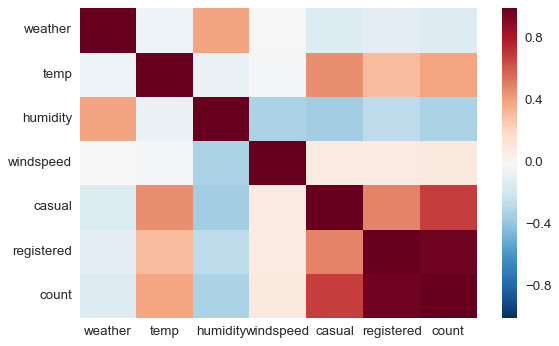

In [102]:
# Correlations with weather features
plt.figure(figsize=(8, 5))
sbr.heatmap(prepared_train[['weather', 'temp', 'humidity', 'windspeed', 'casual', 'registered', 'count']].corr());

### Create cross validation


In case, that we need predict 'future', values train data should be splitted by day value for each month

In [26]:
X_train = prepared_train[train_df.datetime.apply(lambda d: pd.to_datetime(d).day) < 17]
X_test = prepared_train[train_df.datetime.apply(lambda d: pd.to_datetime(d).day) >= 17]

In [27]:
print('train', X_train.shape)
print('test', X_test.shape)

train (9174, 75)
test (1712, 75)


In [20]:
# Divide columns by type for a pipeline
binary_data_columns = ['holiday', 'workingday']
categorical_data_columns = np.concatenate([
    [col for col in prepared_train.columns if col.startswith('season_')],
    [col for col in prepared_train.columns if col.startswith('weather_')],
    [col for col in prepared_train.columns if col.startswith('weekday_')],
    [col for col in prepared_train.columns if col.startswith('month_')],
    [col for col in prepared_train.columns if col.startswith('day_part_')],
    [col for col in prepared_train.columns if col.startswith('hour_')],
])
        
numeric_data_columns = ['temp', 'humidity', 'windspeed']

## Train models

### RandomForest

#### Use as a target count_log

In [21]:
estimator_log_count = Pipeline([
    ('feature_processing', FeatureUnion(transformer_list=[
        ('binary_variables_processing', Pipeline([
            ('selecting', ItemSelector(key=binary_data_columns))
        ])), 
        ('numeric_variables_processing', Pipeline([
            ('selecting', ItemSelector(key=numeric_data_columns)),
            ('scaling', StandardScaler(with_mean = 0))            
        ])),
        ('categorical_variables_processing', Pipeline([
            ('selecting', ItemSelector(key=categorical_data_columns)),
        ])),
    ])),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

In [22]:
estimator_log_count.set_params(
    rf__max_depth=15, 
    rf__min_samples_leaf=2, 
    rf__n_estimators=500
);

In [28]:
estimator_log_count.fit(X_train, X_train.count_log);

In [29]:
evaluate_model(estimator_log_count, 'count_log')

Error on train: 0.0549208576325
Error on test: 0.0972339543915


In [42]:
# the public score is 0.44359
rf_pred_count = predict_test(estimator_log_count, 'count_log')
make_submission(rf_pred_count, 'log_count_solution')

submission_log_count_solution.csv successfully created


#### Use as a target casual_log

In [33]:
estimator_casual = Pipeline([
    ('feature_processing', FeatureUnion(transformer_list=[
        ('binary_variables_processing', Pipeline([
            ('selecting', ItemSelector(key=binary_data_columns))
        ])), 
        ('numeric_variables_processing', Pipeline([
            ('selecting', ItemSelector(key=numeric_data_columns)),
            ('scaling', StandardScaler(with_mean = 0))            
        ])),
        ('categorical_variables_processing', Pipeline([
            ('selecting', ItemSelector(key=categorical_data_columns)),
        ])),
    ])),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

In [34]:
estimator_casual.set_params(
    rf__max_depth=25, 
    rf__min_samples_leaf=5, 
    rf__n_estimators=800
);

In [35]:
estimator_casual.fit(X_train, X_train.casual_log);

In [36]:
evaluate_model(estimator_casual, 'casual_log')

Error on train: 0.170954676374
Error on test: 0.220892068772


In [43]:
rf_pred_cas = predict_test(estimator_casual, 'casual_log')

#### Use as a target registered_log

In [37]:
estimator_registered = Pipeline([
    ('feature_processing', FeatureUnion(transformer_list=[
        ('binary_variables_processing', Pipeline([
            ('selecting', ItemSelector(key=binary_data_columns))
        ])), 
        ('numeric_variables_processing', Pipeline([
            ('selecting', ItemSelector(key=numeric_data_columns)),
            ('scaling', StandardScaler(with_mean = 0))            
        ])),
        ('categorical_variables_processing', Pipeline([
            ('selecting', ItemSelector(key=categorical_data_columns)),
        ])),
    ])),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

In [38]:
estimator_registered.set_params(
    rf__max_depth=25, 
    rf__min_samples_leaf=1, 
    rf__n_estimators=1200
);

In [39]:
estimator_registered.fit(X_train, X_train.registered_log);

In [40]:
evaluate_model(estimator_registered, 'registered_log')

Error on train: 0.0403224649186
Error on test: 0.107321796614


In [44]:
rf_pred_reg = predict_test(estimator_registered, 'registered_log')

#### Get summ of registered and causual

In [45]:
rf_reg_cas = rf_pred_reg + rf_pred_cas

#### Try get mean from count  and registered with causual

In [46]:
rf_mean_log = 0.6 * rf_pred_count + 0.4 * rf_reg_cas

In [47]:
# the public score is 0.44045
make_submission(rf_mean_log, 'rf_mean_log_06_04')

submission_rf_mean_log_06_04.csv successfully created


### XGBoost

#### Use as a target  count_log

In [50]:
estimator_xgb_count = Pipeline([
    ('feature_processing', FeatureUnion(transformer_list=[
        ('binary_variables_processing', Pipeline([
            ('selecting', ItemSelector(key=binary_data_columns))
        ])), 
        ('numeric_variables_processing', Pipeline([
            ('selecting', ItemSelector(key=numeric_data_columns)),
            ('scaling', StandardScaler(with_mean = 0))            
        ])),
        ('categorical_variables_processing', Pipeline([
            ('selecting', ItemSelector(key=categorical_data_columns))
        ])),
    ])),
    ('xgb', XGBRegressor())
])

In [51]:
estimator_xgb_count.set_params(
    xgb__gamma=0.8,
    xgb__max_depth=25,
    xgb__min_child_weight=3,
    xgb__reg_alpha=0.5,
    xgb__reg_lambda=1
);

In [52]:
estimator_xgb_count.fit(X_train, X_train.count_log);

In [53]:
evaluate_model(estimator_xgb_count, 'count_log')

Error on train: 0.0639231818636
Error on test: 0.095707406729


#### Use as a target  registed_log

In [54]:
estimator_xgb_registered = Pipeline([
    ('feature_processing', FeatureUnion(transformer_list=[
        ('binary_variables_processing', Pipeline([
            ('selecting', ItemSelector(key=binary_data_columns))
        ])), 
        ('numeric_variables_processing', Pipeline([
            ('selecting', ItemSelector(key=numeric_data_columns)),
            ('scaling', StandardScaler(with_mean = 0))            
        ])),
        ('categorical_variables_processing', Pipeline([
            ('selecting', ItemSelector(key=categorical_data_columns))
        ])),
    ])),
    ('xgb', XGBRegressor())
])

In [55]:
estimator_xgb_registered.set_params(
    xgb__gamma=0.1,
    xgb__max_depth=18,
    xgb__min_child_weight=7,
    xgb__reg_alpha=1.0,
    xgb__reg_lambda=0.1
);

In [56]:
estimator_xgb_registered.fit(X_train, X_train.registered_log);

In [57]:
evaluate_model(estimator_xgb_registered, 'registered_log')

Error on train: 0.0515802086483
Error on test: 0.10901045611


#### Use as a target causual_log

In [58]:
estimator_xgb_causual = Pipeline([
    ('feature_processing', FeatureUnion(transformer_list=[
        ('binary_variables_processing', Pipeline([
            ('selecting', ItemSelector(key=binary_data_columns))
        ])), 
        ('numeric_variables_processing', Pipeline([
            ('selecting', ItemSelector(key=numeric_data_columns)),
            ('scaling', StandardScaler(with_mean = 0))            
        ])),
        ('categorical_variables_processing', Pipeline([
            ('selecting', ItemSelector(key=categorical_data_columns))
        ])),
    ])),
    ('xgb', XGBRegressor())
])

In [59]:
estimator_xgb_causual.set_params(
    xgb__gamma=0.8,
    xgb__max_depth=5,
    xgb__min_child_weight=1,
    xgb__reg_alpha=0.01,
    xgb__reg_lambda=0.01
);

In [60]:
estimator_xgb_causual.fit(X_train, X_train.casual_log);

In [61]:
evaluate_model(estimator_xgb_causual, 'casual_log')

Error on train: 0.196886803302
Error on test: 0.219172273477


#### Evaluate xgboost models

###### count_log

In [62]:
xgb_count = predict_test(estimator_xgb_count, 'count_log')

In [63]:
# the public score is 0.43442
make_submission(xgb_count, 'xgb_count')

submission_xgb_count.csv successfully created


##### registered + casual

In [64]:
xgb_reg = predict_test(estimator_xgb_registered, 'registered_log')
xgb_caus = predict_test(estimator_xgb_causual, 'casual_log')
xgb_casul_reg = xgb_caus + xgb_reg

In [65]:
# the public score is 0.43291
make_submission(xgb_casul_reg, 'xgb_casul_reg')

submission_xgb_casul_reg.csv successfully created


##### mean for count + casul + reg

In [66]:
# the public score is 0.42859
xgb_mean = (xgb_count + xgb_casul_reg) / 2
make_submission(xgb_mean, 'xgb_mean')

submission_xgb_mean.csv successfully created


### Build ensemble for rf and xgb 

In [68]:
# the public score is 0.42834
ensem_03_07 = 0.2 * rf_mean_log + 0.8 * xgb_mean
make_submission(ensem_03_07, 'ensem_02_08')

submission_ensem_02_08.csv successfully created
